# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Dataset

In [2]:
df = pd.read_csv("../dataset/FullData.csv", low_memory=False)

In [3]:
df.info()
print("\nOriginal number of features: ", len(df.columns))

df['depression'] = df['depression'].map({'Depressed': 1, 'Not Depressed': 0})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36259 entries, 0 to 36258
Columns: 492 entries, SEQN to Rx_days_METHOCARBAMOL
dtypes: float64(299), int64(176), object(17)
memory usage: 136.1+ MB

Original number of features:  492


## Listing all the features available in the dataset

In [4]:
column_names = df.columns.tolist()

num_chunks = len(column_names) // 5
if len(column_names) % 5 != 0:
    num_chunks += 1

for i in range(num_chunks):
    start = i * 5
    end = min((i + 1) * 5, len(column_names))
    print(', '.join(column_names[start:end]))

SEQN, depression, gender, age, race
citizenship, education_level, marital_status, household_size, pregnant
birth_place, veteran, household_income, asthma, asthma_onset
asthma_currently, asthma_emergency, anemia, ever_overweight, blood_transfusion
arthritis, heart_failure, heart_disease, angina, heart_attack
stroke, emphysema, bronchitis, liver_condition, thyroid_problem
bronchitis_currently, liver_condition_currently, thyroid_problem_currently, cancer, first_cancer_type
second_cancer_type, third_cancer_type, fourth_cancer_count, heart_attack_relative, asthma_relative
diabetes_relative, hay_fever, arthritis_onset, heart_failure_onset, heart_disease_onset
angina_onset, heart_attack_onset, stroke_onset, emphysema_onset, bronchitis_onset
liver_condition_onset, thyroid_problem_onset, cancer_onset, arthritis_type, first_cancer_count
second_cancer_count, third_cancer_count, weight, height, BMI
pulse, irregular_pulse, systolic, diastolic, total_cholesterol
HDL, triglyceride, LDL, albumin, ALT


## View sample

In [5]:
df.head()

,SEQN,depression,gender,age,race,citizenship,education_level,marital_status,household_size,pregnant,...,Rx_INSULIN REGULAR,Rx_days_INSULIN REGULAR,Rx_MEMANTINE,Rx_days_MEMANTINE,Rx_DIPHENHYDRAMINE,Rx_days_DIPHENHYDRAMINE,Rx_MINOCYCLINE,Rx_days_MINOCYCLINE,Rx_METHOCARBAMOL,Rx_days_METHOCARBAMOL
0,31131,0,1,44,Black,Citizen,4,Married,4,No,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1,31132,0,0,70,White,Citizen,5,Married,2,Missing,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2,31134,0,0,73,White,Citizen,3,Married,2,Missing,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
3,31139,0,1,18,Other Hispanic,Citizen,0,Never Married,3,No,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
4,31143,0,0,19,White,Citizen,0,Never Married,3,Missing,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


# Understanding the data

## Listing all features with categorical data

In [6]:
df = df.drop('SEQN', axis=1)
categorical_features = df.select_dtypes(include=['object']).columns
for feature in categorical_features:
    print(f"{feature}: [{', '.join(map(str, df[feature].unique()))}]")

race: [Black, White, Other Hispanic, Mexican, Other and Multiracial]
citizenship: [Citizen, Not Citizen, Missing]
marital_status: [Married, Never Married, Widowed, Divorced, Separated, Partner, Missing]
pregnant: [No, Missing, Yes]
birth_place: [USA, Mexico, Elsewhere, Other Spanish Country, Other Non Spanish Country, Missing]
veteran: [No, Yes, Missing]
first_cancer_type: [nan, Colon, Other, Breast, Liver, Bladder, Lung, Melanoma, Skin Other, Mouth, Skin Non Melanoma, Prostate, Cervical, Thyroid, Lymphoma, Uterine, Brain, Stomach, Rectal, Testicular, Kidney, Esophageal, Larynx, Ovarian, Blood, Bone, Leukemia, Gallbladder, Pancreatic, Soft Tissue, Nervous System]
second_cancer_type: [nan, Bone, Ovarian, Kidney, Melanoma, Prostate, Liver, Uterine, Other, Bladder, Skin Non Melanoma, Cervical, Breast, Skin Other, Esophageal, Rectal, Leukemia, Colon, Blood, Lymphoma, Stomach, Thyroid, Mouth, Lung, Larynx, Brain, Pancreatic]
third_cancer_type: [nan, Blood, Skin Non Melanoma, Ovarian, Other,

In [7]:
binary_mapping = {'Yes': 1, 'No': 0, 'Missing': 0}

binary_features = ['pregnant', 'veteran', 'full_time_work', 'vigorous_recreation', 'moderate_recreation', 'lifetime_alcohol_consumption']
for feature in binary_features:
    df[feature] = df[feature].map(binary_mapping)

categorical_features = ['race', 'citizenship', 'marital_status', 'birth_place', 'first_cancer_type', 'second_cancer_type', 'third_cancer_type', 'arthritis_type', 'work_type', 'out_of_work']
for feature in categorical_features:
    most_frequent_category = df[feature].mode()[0]
    df[feature] = df[feature].replace('Missing', 'No')

## Data distribution

In [8]:
print(df['depression'].value_counts())

depression
0    33091
1     3168
Name: count, dtype: int64


## Downsampling the dataset for easier analysis

In [9]:
majority = df[df.depression==0]
minority = df[df.depression==1]

majority_downsampled = majority.sample(len(minority))
df = pd.concat([majority_downsampled, minority])

# Analytics

## Histogram of age distribution of Depressed Individuals

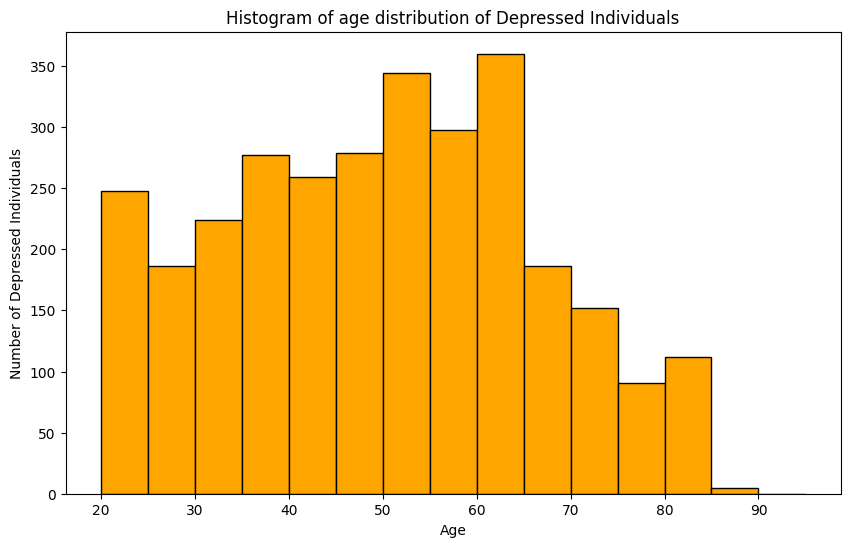

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(df[df['depression'] == 1]['age'], bins=[20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95], edgecolor='black', color='orange')
plt.xlabel('Age')
plt.title('Histogram of age distribution of Depressed Individuals')
plt.ylabel('Number of Depressed Individuals')
plt.show()

## Histogram of depressed individuals suffering from each disease

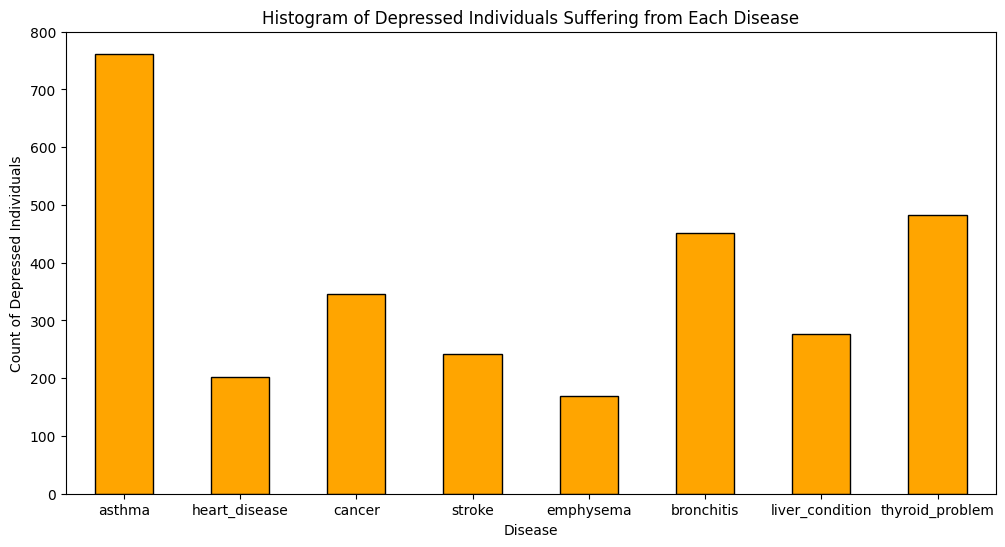

In [11]:
counts_df_depressed = pd.DataFrame()
disease_features = ['asthma', 'heart_disease', 'cancer', 'stroke', 'emphysema', 'bronchitis', 'liver_condition', 'thyroid_problem']

for feature in disease_features:
    counts = df[(df['depression'] == 1) & (df[feature] == 1)].shape[0]
    counts_df_depressed[feature] = [counts]

counts_df_depressed.transpose().plot(kind='bar', legend=False, color='orange', edgecolor='black', figsize=(12, 6))

plt.xticks(rotation=0)
plt.xlabel('Disease')
plt.ylabel('Count of Depressed Individuals')
plt.title('Histogram of Depressed Individuals Suffering from Each Disease')
plt.show()

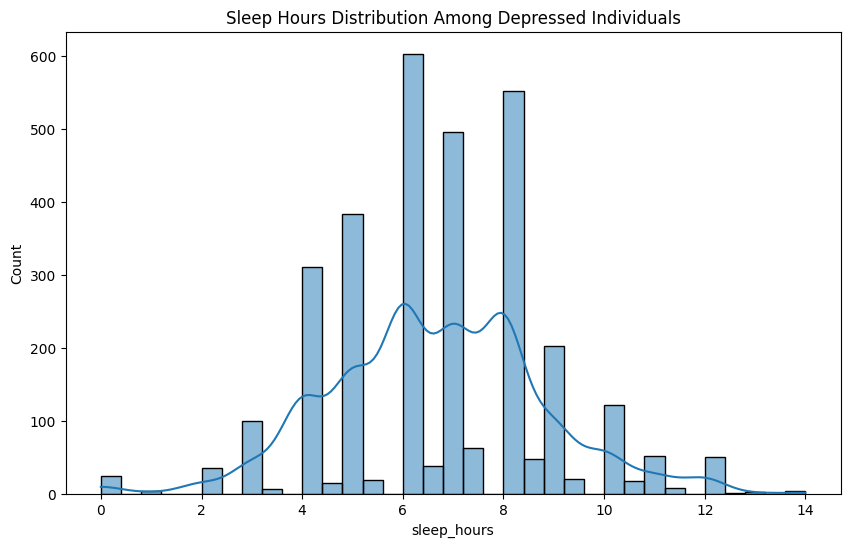

In [12]:
# Depression and Sleep Hours
plt.figure(figsize=(10,6))
sns.histplot(data=df[df['depression'] == 1], x='sleep_hours', kde=True)
plt.title('Sleep Hours Distribution Among Depressed Individuals')
plt.show()

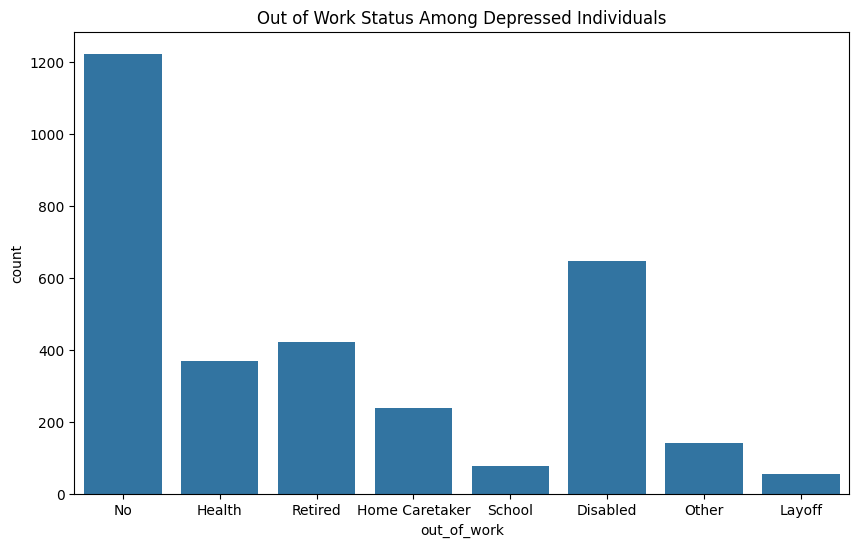

In [13]:
# Depression and Out of Work
plt.figure(figsize=(10,6))
sns.countplot(x='out_of_work', data=df[df['depression'] == 1])
plt.title('Out of Work Status Among Depressed Individuals')
plt.show()

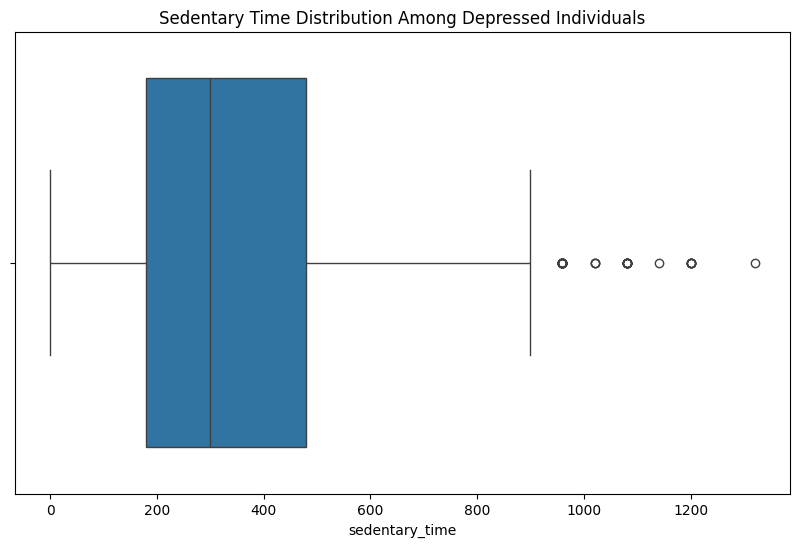

In [14]:
# Depression and Sedentary Time
plt.figure(figsize=(10,6))
sns.boxplot(x='sedentary_time', data=df[df['depression'] == 1])
plt.title('Sedentary Time Distribution Among Depressed Individuals')
plt.show()

In [15]:
categorical_features = df.select_dtypes(include=['object']).columns
print(categorical_features)

le = LabelEncoder()

categorical_features = df.select_dtypes(include=['object']).columns
for feature in categorical_features:
    df[feature] = le.fit_transform(df[feature])

Index(['race', 'citizenship', 'marital_status', 'birth_place',
       'first_cancer_type', 'second_cancer_type', 'third_cancer_type',
       'arthritis_type', 'work_type', 'out_of_work'],
      dtype='object')


In [16]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.to_csv('../dataset/numerical_processed_data.csv', index=False)